# **Model Testing** - Final Predictive Model All Features

**All Features:**

Data columns (total 29 columns):

Specific Identifiers:

- BillID      51067 non-null object


How far it made it:

- PassH       51067 non-null int64
- PassS       51067 non-null int64
- PLawDate    1393 non-null object - MAKE BOOL?
- PLawNum     51067 non-null object
- PLaw        51067 non-null int64
- Veto        51067 non-null int64

Bill Descriptive Info:

- BillType    51067 non-null object
- Title       51067 non-null object
- Cong        51067 non-null int64
- Summary     51017 non-null object - REMOVE NULL
- ImpBill     51067 non-null int64
- Chamber     51067 non-null int64 (H or S)

Info about Rep Bill Proposer:

- Cosponsr    51067 non-null float64
- IntrDate    51025 non-null object - REMOVE NULL
- Mult        51067 non-null int64
- Class       51067 non-null float64
- District    51067 non-null float64
- FrstConH    51067 non-null float64
- FrstConS    51067 non-null float64
- Gender      51067 non-null int64
- MRef        51067 non-null int64
- NameFull    51067 non-null object
- Party       51067 non-null float64
- Postal      51067 non-null object
- Majority    51067 non-null int64

Other general bill info:

- Major       51067 non-null float64
- Minor       51067 non-null float64

The URL:

- URL         51067 non-null object


List of the models to test and the parameters to tune:
  
**Models:**
- Naive Bayes
- Logistic Regression
- Random Forest
- SVM

**Evaluations:**
- Accuracy, precision, recall, f1
- Confusion Matrix
- ROC/AUC

**Class Imbalance Issues:**
- Run a model on just one topic with good class distribution:
- Undersampling
- Use top 10 words for each PassH as features


- try running models with only words
- ADD top five pass, top five not pass


- try one without 112th
    

In [1]:
# ! pip install sklearn-pandas

# **Query Data**

In [2]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [3]:
bills_db = DbSchema(config)


In [4]:
#Full dataframe for running models

df = bills_db.query("""
    SELECT cb.BillID, 
        cb.Chamber,
        cb.IntrDate,
        cb.Title, 
        cb.Cosponsr, 
        cb.Mult,
        cb.District,
        cb.FrstConH,
        cb.Gender,
        cb.NameFull,
        cb.Party,
        cb.Postal,
        cb.PassH,
        cb.Majority,
        tp.dominant_topic         
    FROM 
        con_bills.current_bills as cb
    JOIN
        con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >= 110""")


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51067 entries, 0 to 51066
Data columns (total 15 columns):
BillID            51067 non-null object
Chamber           51067 non-null int64
IntrDate          51025 non-null object
Title             51067 non-null object
Cosponsr          51067 non-null float64
Mult              51067 non-null int64
District          51067 non-null float64
FrstConH          51067 non-null float64
Gender            51067 non-null int64
NameFull          51067 non-null object
Party             51067 non-null float64
Postal            51067 non-null object
PassH             51067 non-null int64
Majority          51067 non-null int64
dominant_topic    51067 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usage: 5.8+ MB


# **Final Data Cleaning**


In [6]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [7]:
def cosponsr_clean(x):
    if x <= 44.0:
        return x
    if x > 44.0:
        return 50
        

In [8]:
def party_clean(x):
    if x == 100.0:
        return 0
    if x == 200.0:
        return 1
    if x == 328.0:
        return 3

In [9]:
def billtype_clean(x):
    if x == 'hr':
        return 0
    if x == 's':
        return 1
     

In [10]:
def name_clean(x):
    if x >= 400:
        return 1
    if x >= 300 and x <= 399:
        return 2
    if x >= 200 and x <= 299:
        return 3
    if x >= 150 and x <= 199:
        return 4
    if x >=100 and x <= 149:
        return 5
    if x >=50 and x <= 99:
        return 6
    if x < 50:
        return 7

In [11]:
df['IntrDate'].isnull().sum()

42

In [12]:
df.dropna(subset=['IntrDate'], inplace=True)

In [13]:
df.shape

(51025, 15)

**Add Columns:**

Final Clean to Dataframe for Modeling:

In [14]:
def final_columns(df):
        
    df['month'] = df['IntrDate'].apply(lambda x: x.strftime('%B')) 
    
    names = df['NameFull'].value_counts()

    names_dict = names.to_dict() #converts to dictionary

    df['sponsor_count'] = df['NameFull'].map(names_dict) 
    
    df['title_len'] = [len(summary) for summary in df['Title']]
    
    df['clean_cosponsr'] = df['Cosponsr'].map(lambda x: cosponsr_clean(x))

    df['clean_party'] = df['Party'].map(lambda x: party_clean(x))
    
    df['ranked_sponsor_count'] = df['sponsor_count'].map(lambda x: name_clean(x))
    
    
    df.drop(columns=['Cosponsr', 'Party', 'NameFull', 'Title', 'IntrDate', 'sponsor_count'], inplace=True)
        
    return df

In [15]:
final_df = final_columns(df)

In [16]:
final_df.head()

,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,PassH,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
0,110-HR-1,0,1,2.0,0.0,0,MS,1,1,5,January,128,50.0,0,6
1,110-HR-10,0,0,8.0,0.0,1,CA,0,1,10,January,21,0.0,0,7
2,110-HR-100,0,0,53.0,0.0,1,CA,0,1,4,January,150,10.0,0,5
3,110-HR-1000,0,0,0.0,0.0,1,DC,0,1,10,February,136,50.0,0,3
4,110-HR-1001,0,0,5.0,0.0,0,SC,0,1,5,February,201,0.0,0,7


In [17]:
final_df['PassH'].value_counts()

0    47004
1     4021
Name: PassH, dtype: int64

In [18]:
final_df.isnull().sum()

BillID                  0
Chamber                 0
Mult                    0
District                0
FrstConH                0
Gender                  0
Postal                  0
PassH                   0
Majority                0
dominant_topic          0
month                   0
title_len               0
clean_cosponsr          0
clean_party             0
ranked_sponsor_count    0
dtype: int64

# Preprocesing:


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


**Create preprocessing pipeline:**

- Numeric Features
- Categorical Features

In [20]:
no_change_features = ['PassH', 'Chamber','Mult', 'Gender', 'Majority']
# no_change_transformer = Pipeline(steps=[
#     ()])

In [21]:
# word_features = ['Title']
# word_transformer = Pipeline(steps=[
#     ('tfidf', CountVectorizer(tokenizer=tokenizer))])

# for adding to preprocessor
# ('word', word_transformer, word_features),

In [22]:
numeric_features = ['clean_cosponsr', 'title_len']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [23]:
categorical_features = ['Postal', 'dominant_topic', 'District', 'clean_party', 'FrstConH', 'month', 'ranked_sponsor_count']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [24]:
"""Append all to preprocessor for use in pipeline"""
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



**Train test split**

In [25]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['PassH'], axis=1)
y = df['PassH']


In [26]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [27]:
X_train.shape

(40820, 14)

In [28]:
X_test.shape

(10205, 14)

In [29]:
y_train.shape

(40820,)

In [30]:
y_test.shape

(10205,)

# **Modeling**


- Naive Bayes
- Logistic Regression
- SVM
- SGD
- Random Forest

# **Naive Bayes** - Base Classifier

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


nb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())]) #get parameters
parameters = None

nb.fit(X_train, y_train)

nb_y_pred = nb.predict(X_test)

print(confusion_matrix(y_test, nb_y_pred))
print(classification_report(y_test, nb_y_pred))

nb_confusion_matrix = (confusion_matrix(y_test, nb_y_pred))

[[9319   23]
 [ 803   60]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9342
           1       0.72      0.07      0.13       863

    accuracy                           0.92     10205
   macro avg       0.82      0.53      0.54     10205
weighted avg       0.90      0.92      0.89     10205



In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(nb_confusion_matrix/np.sum(nb_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Text(0.5, 1, 'Confusion Matrix')

# **Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.


In [33]:
from sklearn.linear_model import LogisticRegression

# Bring in OHE?

lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced', C=.8, n_jobs=-1))]) #get parameters

# Logistic Regression Classifier
# lr_classifier = LogisticRegression(class_weight='balanced', C=.8, n_jobs=-1))

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

[[6766 2576]
 [ 256  607]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.83      9342
           1       0.19      0.70      0.30       863

    accuracy                           0.72     10205
   macro avg       0.58      0.71      0.56     10205
weighted avg       0.90      0.72      0.78     10205



In [34]:
# Probability estimates.
lr_clf.predict_proba(X_test)

array([[0.42283644, 0.57716356],
       [0.75200525, 0.24799475],
       [0.86363468, 0.13636532],
       ...,
       [0.78674853, 0.21325147],
       [0.88086478, 0.11913522],
       [0.68354645, 0.31645355]])

In [35]:
# Return the mean accuracy on the given test data and labels.
lr_clf.score(X_test, y_test)

0.7224889759921607

Text(0.5, 1, 'Confusion Matrix')

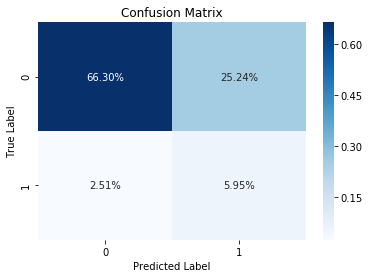

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

**ROC/AUC Curve**

In [37]:
#for ROC/AUC Curve
lr_dec = lr_clf.decision_function(X_test)

In [38]:
import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.7138082093775031

For ROC/AUC - Edit the threshold, which starts at 0.

Test AUC: 0.7982842285416314


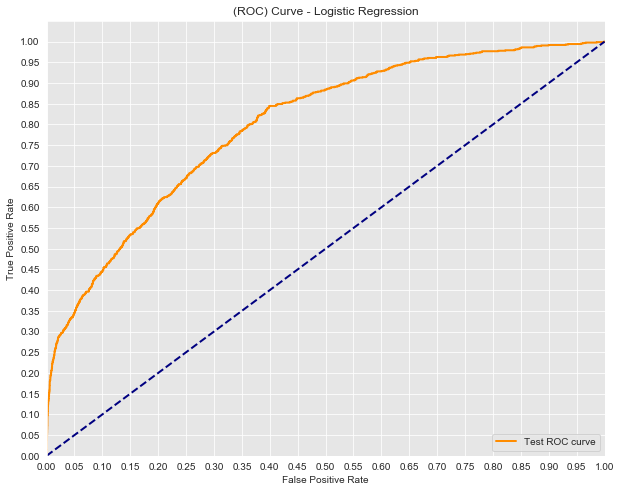

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [40]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.38


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.38')

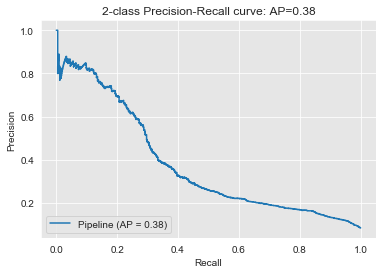

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

# **SVM Classifier:**

In [42]:
# from sklearn.svm import SVC

# svm = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', SVC(class_weight = 'balanced', C=1e5, kernel='linear'))])


# svm.fit(X_train, y_train)

# svm_y_pred = svm.predict(X_test)

# print(confusion_matrix(y_test, svm_y_pred))
# print(classification_report(y_test, svm_y_pred))

# svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

In [43]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# #shows percent data represented in each quadrant

# sns.heatmap(svm_confusion_matrix/np.sum(svm_confusion_matrix), annot=True, 
#             fmt='.2%', cmap='Blues')

# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix')

In [44]:
# import numpy as np
# from sklearn.metrics import roc_auc_score
# svm_roc_auc = roc_auc_score(y_test, svm_y_pred)
# svm_roc_auc

# #This is an okish AUC Score

In [45]:
# svm_dec = svm.decision_function(X_test)

In [46]:
# #AUC/ROC Curve

# test_fpr, test_tpr, test_thresholds = roc_curve(y_test, svm_dec)

# print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# plt.figure(figsize=(10, 8))
# lw = 2

# plt.plot(test_fpr, test_tpr, color='darkorange',
#          lw=lw, label='Test ROC curve')

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('(ROC) Curve - SVM Classifier')
# plt.legend(loc='lower right')
# plt.show()

In [47]:
# from sklearn.metrics import average_precision_score

# svm_average_precision = average_precision_score(y_test, svm_dec)

# print('Average precision-recall score: {0:0.2f}'.format(
#       lr_average_precision))

In [48]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
# import matplotlib.pyplot as plt

# disp = plot_precision_recall_curve(svm, X_test, y_test)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(svm_average_precision))

# **SGD Classifer**

In [49]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss='log', class_weight='balanced', learning_rate='optimal'))])


sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

print(confusion_matrix(y_test, sgd_y_pred))
print(classification_report(y_test, sgd_y_pred))

sg_confusion_matrix = confusion_matrix(y_test, sgd_y_pred)

[[7280 2062]
 [ 325  538]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      9342
           1       0.21      0.62      0.31       863

    accuracy                           0.77     10205
   macro avg       0.58      0.70      0.58     10205
weighted avg       0.89      0.77      0.81     10205



Text(0.5, 1, 'Confusion Matrix')

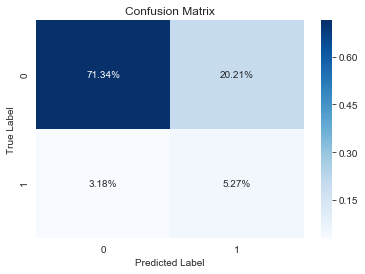

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(sg_confusion_matrix/np.sum(sg_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [51]:
sgd_dec = sgd.decision_function(X_test)

In [52]:
import numpy as np
from sklearn.metrics import roc_auc_score
sgd_roc_auc = roc_auc_score(y_test, sgd_y_pred)
sgd_roc_auc

#This is a terrible AUC score!

0.7013415534772007

Test AUC: 0.7965921232386513


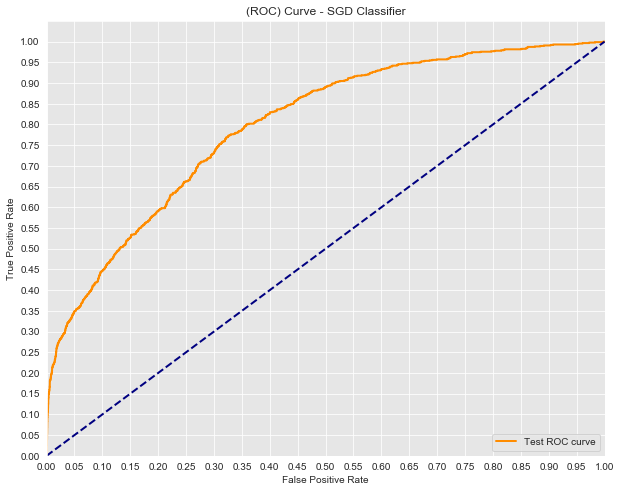

In [53]:
#AUC/ROC Curve

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, sgd_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - SGD Classifier')
plt.legend(loc='lower right')
plt.show()

# **Random Forest**

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [54]:
from sklearn.ensemble import RandomForestClassifier

#add bag of trees?
#add OHE

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=100, class_weight="balanced"))])


rf_pipeline.fit(X_train, y_train) 

rf_y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

[[9273   69]
 [ 622  241]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9342
           1       0.78      0.28      0.41       863

    accuracy                           0.93     10205
   macro avg       0.86      0.64      0.69     10205
weighted avg       0.92      0.93      0.92     10205



Text(0.5, 1, 'Confusion Matrix')

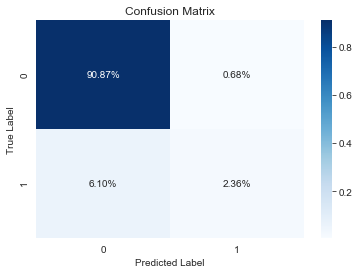

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [56]:
feature_names_cat = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [57]:
# feature_names_cat

In [58]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

150

In [59]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [60]:
new_indices

array([  1,   0,  65,  71,  64, 131, 149, 139, 135, 138])

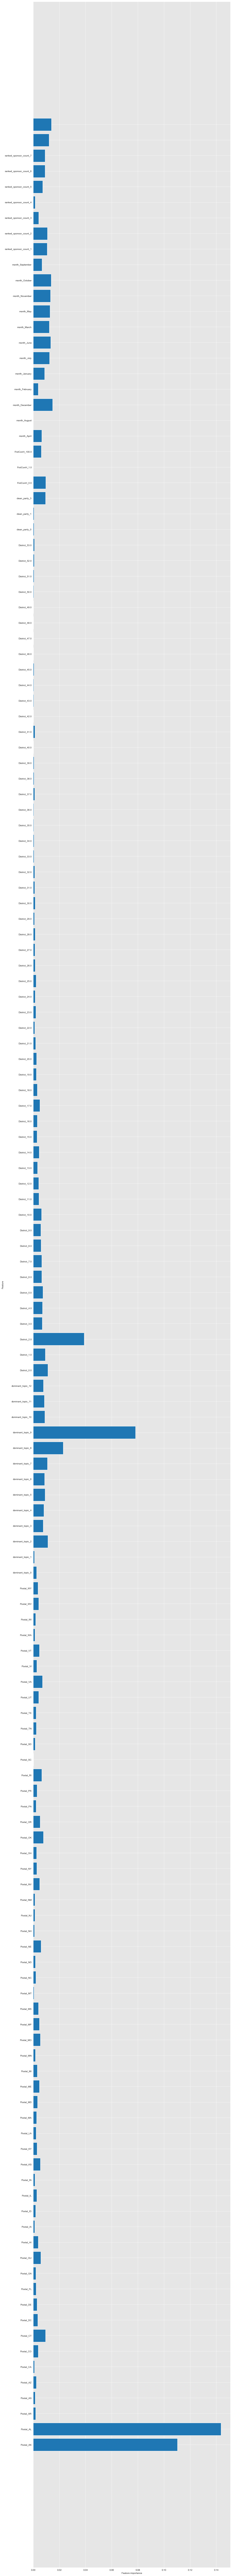

In [61]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(150), importances, align='center') 
    
    plt.yticks(np.arange(150), feature_names_cat) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)

In [62]:
import numpy as np
from sklearn.metrics import roc_auc_score
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_roc_auc

#This is a medium AUC score!

0.6359362011057601

# **FINAL MODEL**


https://www.kaggle.com/selener/multi-class-text-classification-tfidf

# Comparing all Models:

In [63]:
models = [
    RandomForestClassifier(class_weight="balanced", n_estimators=100, max_depth=5, random_state=2),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=2, class_weight="balanced"),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

NameError: name 'LinearSVC' is not defined

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc